# Diabetic Rethinoplasty: Image Classification with CNN 

This Jupyter Notebook contains our solution for classifying the diabetic rethinoplasty data set using the EfficientNet architecture. 

Submitted by: 
* Lara Noe (217461)
* Hiroya Taguchi ()

## Import all necessary libraries

In [137]:
import tensorflow as tf
import os
import cv2
import datetime
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import preprocess_input

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

## Loading data from directory

In [138]:
# Step 1: Loading the data from directory

train_dir = "../DR_data_cropped_classes/train/"
test_dir = "../DR_data_cropped_classes/test/"

In [139]:
batch_size = 32
img_width = img_height = 224
img_size = (img_width, img_height)
seed = 42
lr = 0.001

In [140]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, 
    validation_split = 0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
)

Found 4080 files belonging to 5 classes.
Using 3264 files for training.


In [141]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, 
    validation_split = 0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
)

Found 4080 files belonging to 5 classes.
Using 816 files for validation.


In [142]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, 
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
)

Found 501 files belonging to 5 classes.


In [143]:
class_names=train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4']


### Some samples from the training data set

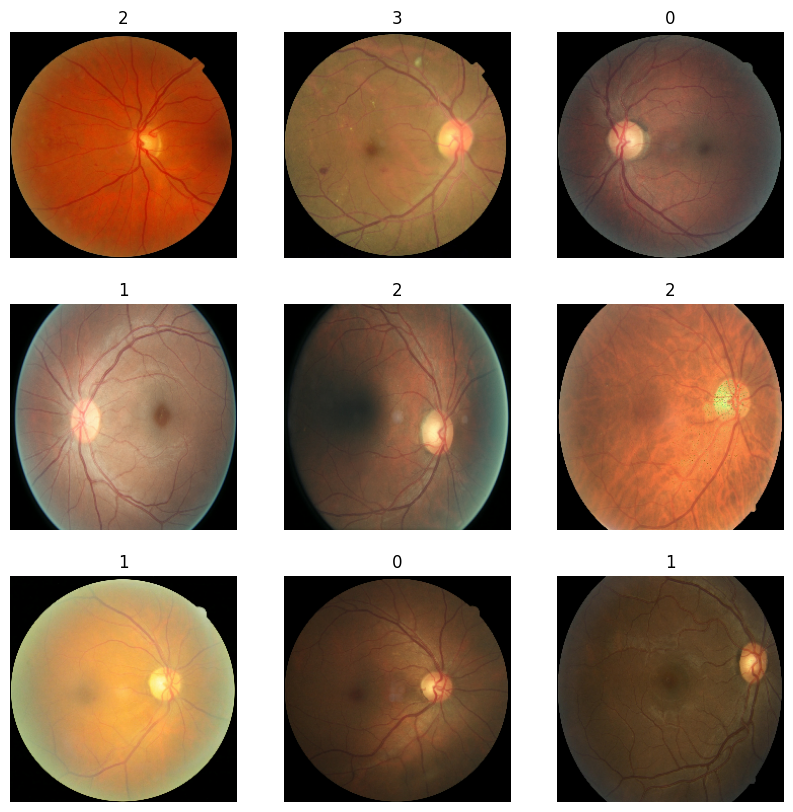

In [144]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [145]:
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))

In [146]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

* Rotation:
* Flip: Horizontal to create more even distribution between "left" and "right" eye -> prevent model from viewing light spot where eye nerve enters as an important feature
* Brightness: Some images very dark, others very light

In [147]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomBrightness((-0.3, 0.4)),
        layers.RandomContrast(0.2),
        #layers.RandomRotation(0.1),
        #layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
        layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode='constant'),
    ]
)


2024-01-04 12:45:13.258877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:342: Filling up shuffle buffer (this may take a while): 72 of 1000
2024-01-04 12:45:16.224683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


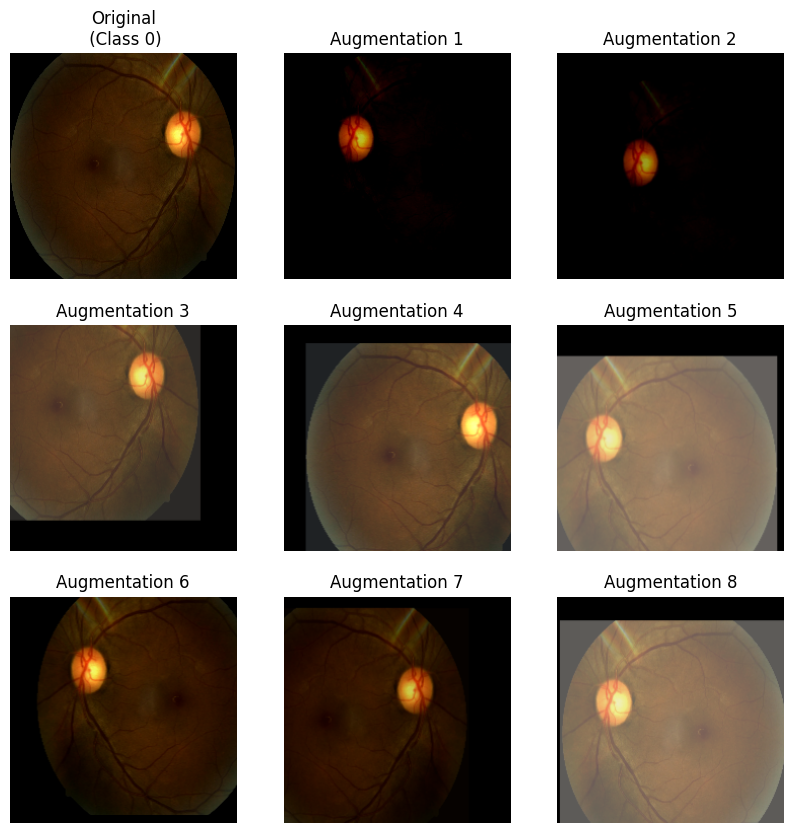

In [148]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(f"Augmentation {i}")
        plt.axis("off")

    ax = plt.subplot(3, 3, 1)
    plt.imshow(first_image.numpy().astype("int32"))
    plt.title(f"Original\n (Class {labels[0]})")
    plt.axis("off")


# Defining the Model


## Testing EfficientNet: Transfer Learning

Small training set, so need to apply techniques to deal with little data. Besides using data augmentation techniques it is suggested to use a smaller model architecture:

https://hackernoon.com/7-effective-ways-to-deal-with-a-small-dataset-2gyl407s

List of small but efficient architectures: <br>
https://towardsdatascience.com/3-small-but-powerful-convolutional-networks-27ef86faa42d

Additionally: make training faster, since we don't have access to a GPU so training bigger models very time consuming

In [149]:
input = keras.Input(shape=(*(img_size), 3))
augmented_inputs = data_augmentation(input)

base_model = EfficientNetB2(
    weights='imagenet', 
    include_top=False, 
    input_tensor = augmented_inputs, 
    input_shape=(*(img_size), 3))

base_model.trainable = False

#base_model.summary()

In [150]:
input_layer = base_model.input

x = base_model.output
x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)

x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.3)(x)

output = layers.Dense(5,
                      activation='softmax',
                      name='output')(x)

model = tf.keras.Model(inputs=input_layer, outputs=output)
#model.summary()

In [151]:
# Compile the model
model.compile(optimizer=optimizers.Adam(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [152]:
# Step 5: Adding early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-8)

callbacks = [early_stopping, reduce_lr]

# Training the Model

Training improves slower than in other models, but validation better and more epochs possible since time per epoch not as long.

Adjusted Hyperparameters:
* smaller learn rate (0.001)
* impacient learn rate reduction (after 2 epochs without improvement) to avoid plateaus
* Changed train/val split from 80/20 to 85/15 to make training set slightly bigger (hopefully more generalized training results)

Slower learning, but more stable improvements on validation set

In [153]:
init_time = datetime.datetime.now()
epochs = 20

# Train the model
history = model.fit(
    train_ds,
    epochs=epochs, 
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr]
)

requared_time = datetime.datetime.now() - init_time
print(f'\nRequired time:  {str(requared_time)}\n')

Epoch 1/20
102/102 [==============================] - 224s 2s/step - loss: 1.6861 - accuracy: 0.2932 - val_loss: 1.3774 - val_accuracy: 0.3689 - lr: 0.0010
Epoch 2/20
102/102 [==============================] - 199s 2s/step - loss: 1.4790 - accuracy: 0.3634 - val_loss: 1.2639 - val_accuracy: 0.4216 - lr: 0.0010
Epoch 3/20
102/102 [==============================] - 199s 2s/step - loss: 1.4118 - accuracy: 0.3827 - val_loss: 1.2896 - val_accuracy: 0.3860 - lr: 0.0010
Epoch 4/20
102/102 [==============================] - 202s 2s/step - loss: 1.3761 - accuracy: 0.3820 - val_loss: 1.2410 - val_accuracy: 0.4424 - lr: 0.0010
Epoch 5/20
102/102 [==============================] - 199s 2s/step - loss: 1.3360 - accuracy: 0.4105 - val_loss: 1.2167 - val_accuracy: 0.4412 - lr: 0.0010
Epoch 6/20
102/102 [==============================] - 200s 2s/step - loss: 1.3310 - accuracy: 0.4090 - val_loss: 1.2051 - val_accuracy: 0.4424 - lr: 0.0010
Epoch 7/20
102/102 [==============================] - 199s 2s/st

### Saving model and training history locally 

In [154]:
time_stamp = datetime.datetime.now().strftime('%Y-%m-%d,%H:%m:%S')

In [155]:
model.save(f'models/cnn_{time_stamp}.keras')

In [156]:
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = f'training_history/history_{time_stamp}.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# Model Evaluation

## Load most recent model and history

In [157]:
loaded_model = models.load_model(f'models/cnn_{time_stamp}.keras')

In [158]:
loaded_history = pd.read_json(f'training_history/history_{time_stamp}.json')

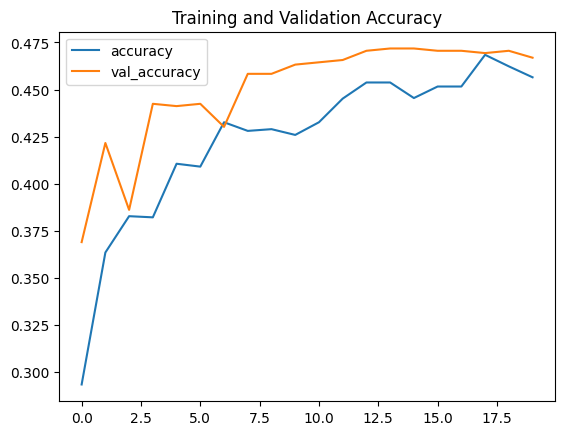

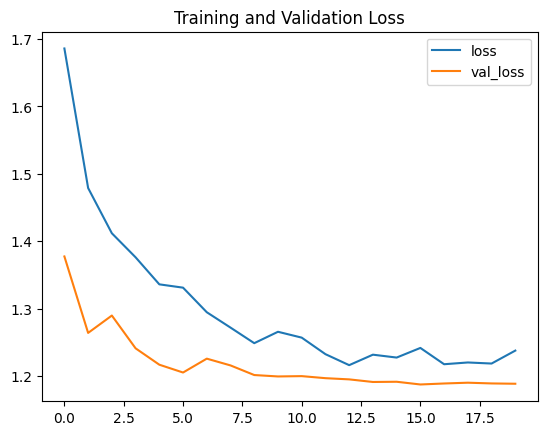

In [159]:
loaded_history[['accuracy','val_accuracy']].plot()
plt.title("Training and Validation Accuracy")
loaded_history[['loss','val_loss']].plot()
plt.title("Training and Validation Loss")
plt.show()

In [160]:
# Evaluate the model on the test set
test_loss, test_accuracy = loaded_model.evaluate(test_ds)
    
# Print the test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss}')  

16/16 [==============================] - 32s 2s/step - loss: 1.2328 - accuracy: 0.4271
Test Accuracy: 42.71%
Test Loss: 1.2328122854232788


### Fine Tuning

In [161]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
#base_model.trainable = True
#model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

## Confusion Matrix

In [162]:
# Generate predictions
predictions = loaded_model.predict(test_ds)

# Extract true labels from the test dataset
true_labels = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Identify correct and incorrect predictions
correct_predictions = np.where(predicted_labels == true_labels)[0]
incorrect_predictions = np.where(predicted_labels != true_labels)[0]

16/16 [==============================] - 27s 1s/step


Classification Report


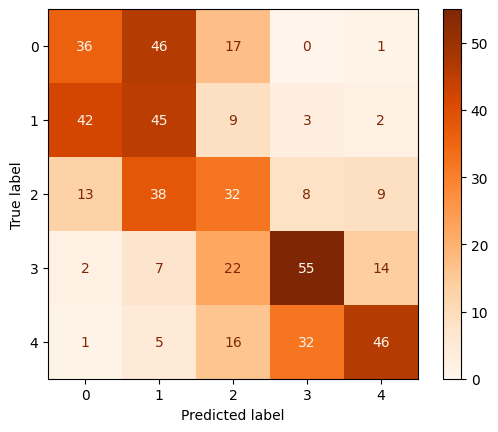

In [163]:
cm = confusion_matrix(true_labels, predicted_labels)
print('Classification Report')
target_names = ['0', '1', '2', '3', '4']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Oranges)
plt.show()

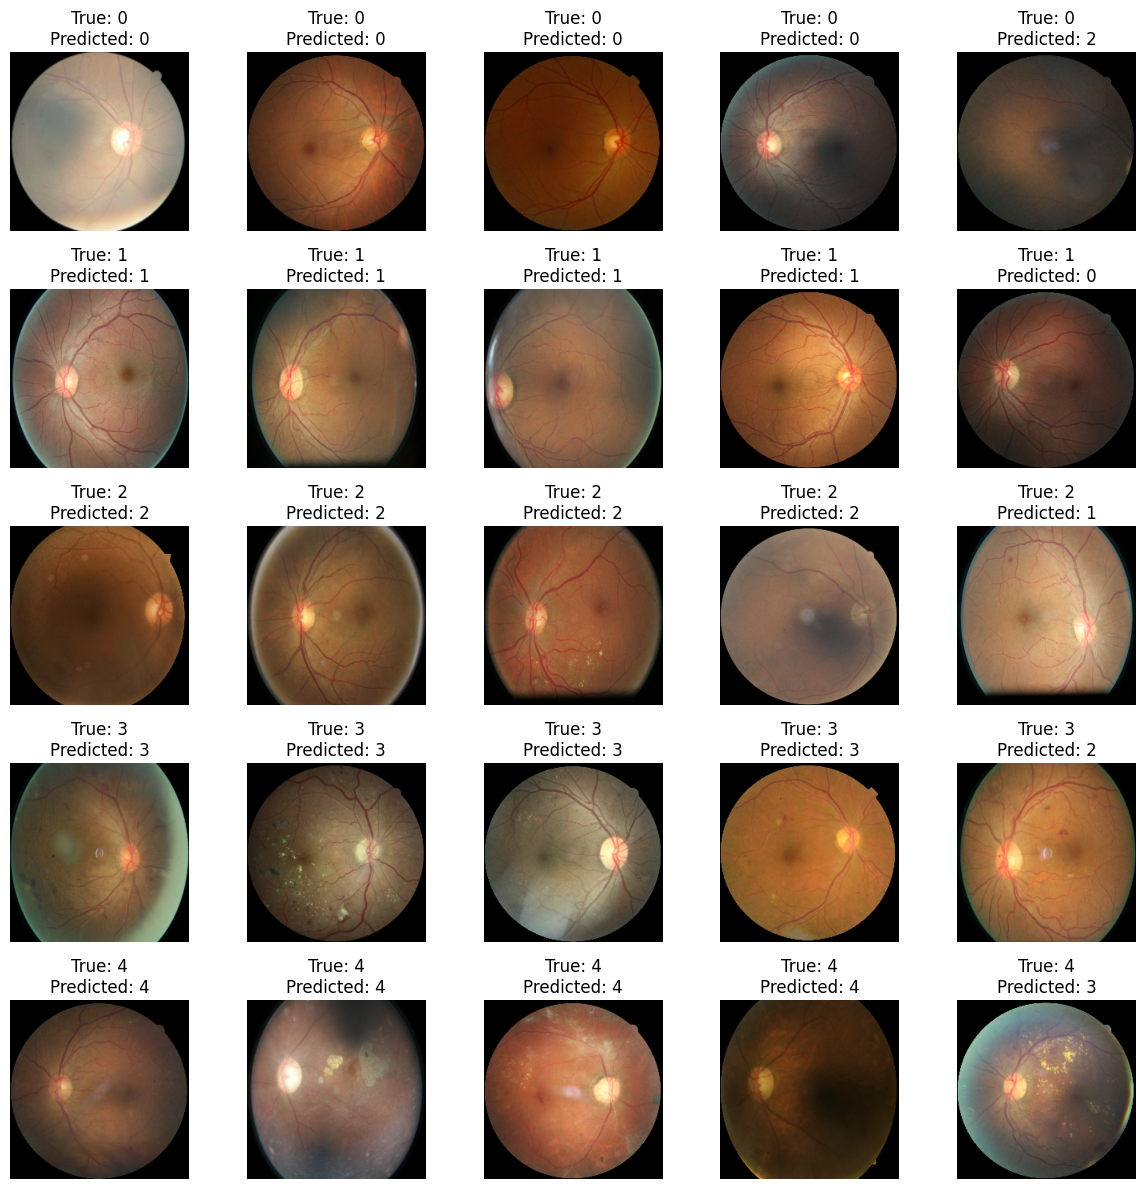

In [164]:
def display_classwise_examples(images, true_labels, predicted_labels, title, num_classes=5):
    classes = np.unique(true_labels)
    
    plt.figure(figsize=(12, 12))
    
    for class_id in classes:
        correct_indices = np.where((true_labels == class_id) & (predicted_labels == class_id))[0]
        incorrect_indices = np.where((true_labels == class_id) & (predicted_labels != class_id))[0]
        
        # Display four correctly classified images
        for i in range(min(4, len(correct_indices))):
            plt.subplot(num_classes, 5, class_id * 5 + i + 1)
            plt.imshow(images[correct_indices[i]].numpy() / 255.0)
            plt.title(f'True: {class_id}\nPredicted: {predicted_labels[correct_indices[i]]}', fontsize=12)
            plt.axis('off')

        # Display one incorrectly classified image
        if len(incorrect_indices) > 0:
            plt.subplot(num_classes, 5, class_id * 5 + 5)
            plt.imshow(images[incorrect_indices[0]].numpy() / 255.0)
            plt.title(f'True: {class_id}\nPredicted: {predicted_labels[incorrect_indices[0]]}', fontsize=12)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display class-wise examples
display_classwise_examples(
    [image for image, _ in test_ds.unbatch()],
    true_labels,
    predicted_labels,
    title='Class-wise Examples'
)

## Attention Map

In [165]:
#last_conv_layer_name = "block7a_project_conv"
last_conv_layer_name = "top_conv"

#Paths to one sample image per class 
samples = [
    "../DR_data_cropped_classes/test/0/102_right.jpeg",
    "../DR_data_cropped_classes/test/1/2430_left.jpeg",
    "../DR_data_cropped_classes/test/2/1541_right.jpeg",
    "../DR_data_cropped_classes/test/3/5298_right.jpeg",
    "../DR_data_cropped_classes/test/4/1350_left.jpeg"
]

### Grad-CAM algorithm
https://keras.io/examples/vision/grad_cam/ <br>
https://www.kaggle.com/code/databeru/fish-classifier-grad-cam-viz-acc-99-89

In [166]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [167]:
def save_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))
    return superimposed_img

1/1 [==============================] - 2s 2s/step
True class: 0 - Predicted class: 2
1/1 [==============================] - 0s 85ms/step
True class: 1 - Predicted class: 1
1/1 [==============================] - 0s 89ms/step
True class: 2 - Predicted class: 2
1/1 [==============================] - 0s 87ms/step
True class: 3 - Predicted class: 2
1/1 [==============================] - 0s 91ms/step
True class: 4 - Predicted class: 3


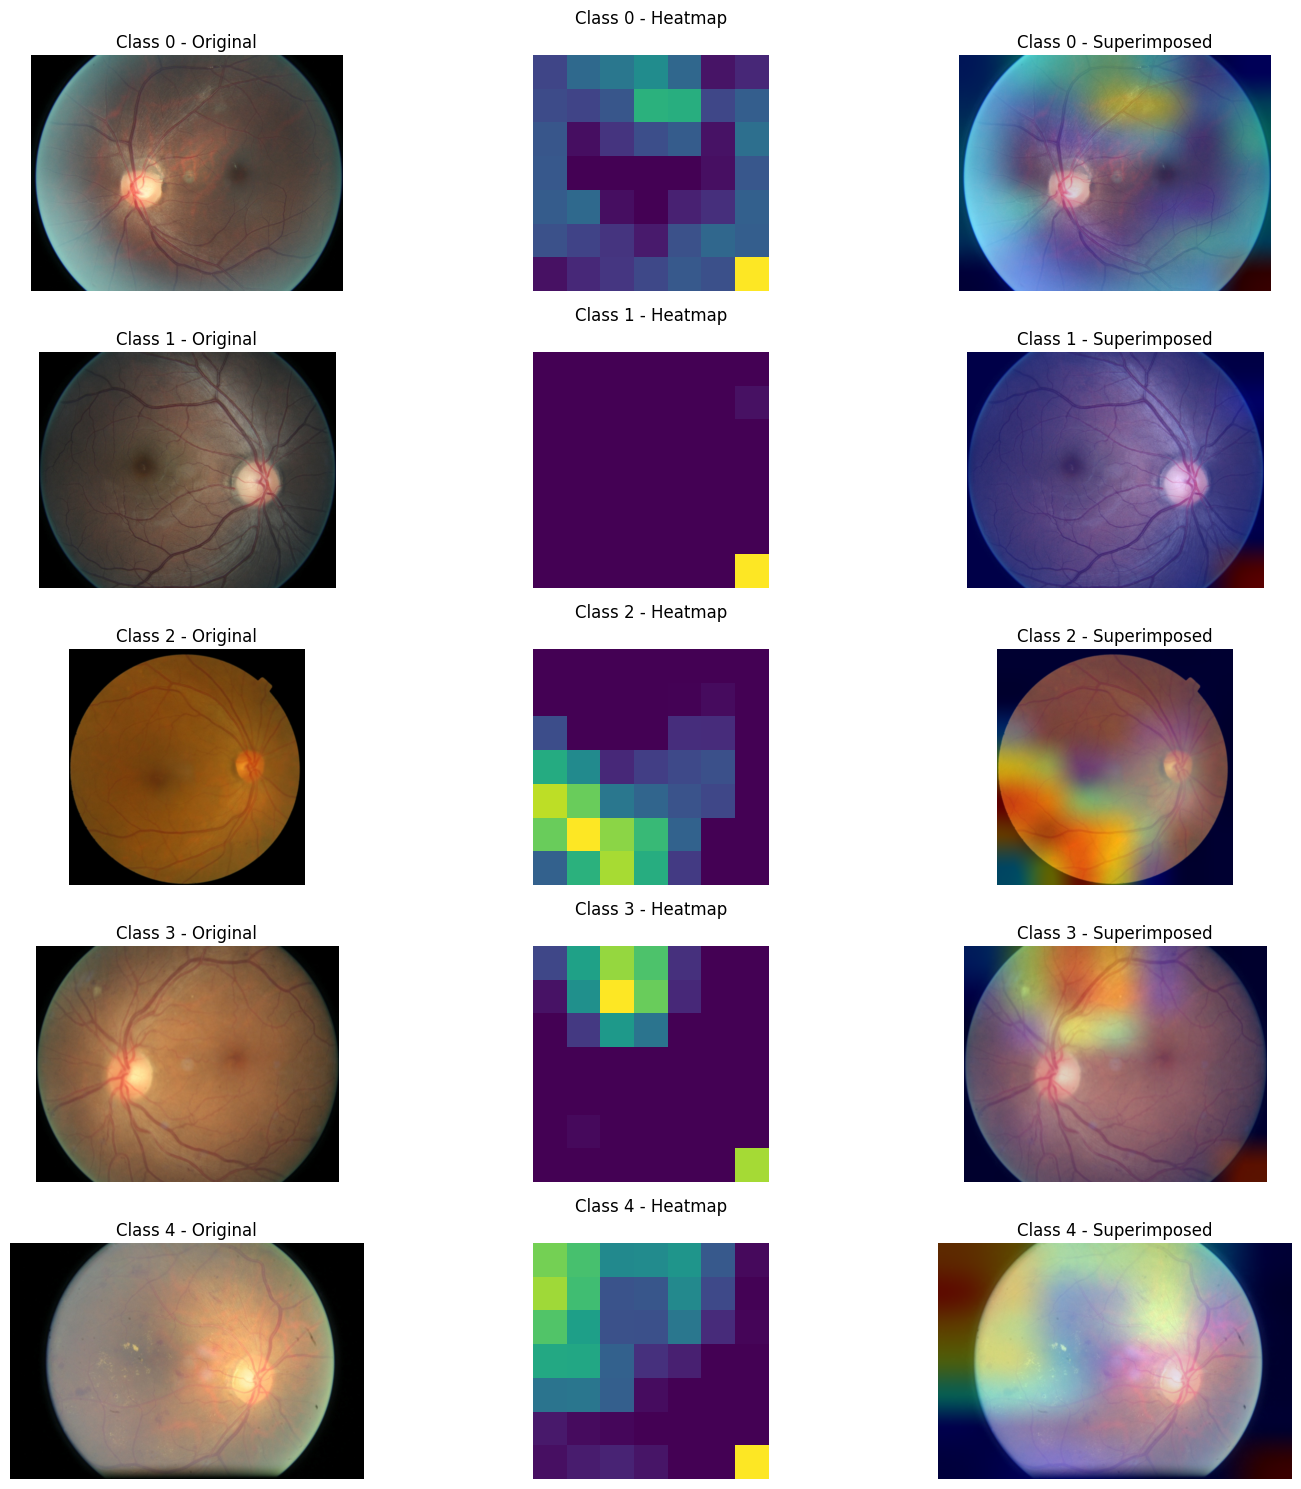

In [168]:
# Create a 2x5 grid for each sample
fig, axs = plt.subplots(5, 3, figsize=(15, 15))

for i, sample_path in enumerate(samples):
    
    # Prepare image
    img_array = preprocess_input(get_img_array(sample_path, size=img_size))

    # Print the predicted class
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds[0])
    print(f"True class: {i} - Predicted class: {predicted_class}")

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, loaded_model, last_conv_layer_name)

    # Superimpose the heatmap on the image
    superimposed = save_gradcam(sample_path, heatmap, f"heatmaps/cam{i}.jpg")

    # Display the heatmap on the left and the superimposed image on the right
    axs[i, 0].imshow(load_img(sample_path))
    axs[i, 0].set_title(f"Class {i} - Original")
    axs[i, 0].axis('off')
    
    axs[i, 1].matshow(heatmap)
    axs[i, 1].set_title(f"Class {i} - Heatmap")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(superimposed)
    axs[i, 2].set_title(f"Class {i} - Superimposed")
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()